In [21]:
import tensorflow as tf
try:
    import deephyper
    print(deephyper.__version__)
except (ImportError, ModuleNotFoundError):
    !pip install deephyper

try:
    import ray
except (ImportError, ModuleNotFoundError):
    !pip install ray


0.7.0


In [22]:
import json

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K

In [23]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = str(3)
os.environ["AUTOGRAPH_VERBOSITY"] = str(0)

In [24]:
from tensorflow.python.client import device_lib


def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == "GPU"]


n_gpus = len(get_available_gpus())
if n_gpus > 1:
    n_gpus -= 1

is_gpu_available = n_gpus > 0

if is_gpu_available:
    print(f"{n_gpus} GPU{'s are' if n_gpus > 1 else ' is'} available.")
else:
    print("No GPU available")

No GPU available


In [25]:
def load_data():
    file_url = "http://storage.googleapis.com/download.tensorflow.org/data/heart.csv"
    dataframe = pd.read_csv(file_url)

    val_dataframe = dataframe.sample(frac=0.2, random_state=1337)
    train_dataframe = dataframe.drop(val_dataframe.index)

    return train_dataframe, val_dataframe


def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("target")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

In [26]:
def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = tf.keras.layers.Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = (
        tf.keras.layers.StringLookup if is_string else tf.keras.layers.IntegerLookup
    )
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature

In [27]:
def count_params(model: tf.keras.Model) -> dict:
    """Evaluate the number of parameters of a Keras model.

    Args:
        model (tf.keras.Model): a Keras model.

    Returns:
        dict: a dictionary with the number of trainable ``"num_parameters_train"`` and
        non-trainable parameters ``"num_parameters"``.
    """

    def count_or_null(p):
        try:
            return K.count_params(p)
        except:
            return 0

    num_parameters_train = int(
        np.sum([count_or_null(p) for p in model.trainable_weights])
    )
    num_parameters = int(
        np.sum([count_or_null(p) for p in model.non_trainable_weights])
    )
    return {
        "num_parameters": num_parameters,
        "num_parameters_train": num_parameters_train,
    }

In [42]:
def run(config: dict):
    tf.autograph.set_verbosity(0)
    # Load data and split into validation set
    train_dataframe, val_dataframe = load_data()
    train_ds = dataframe_to_dataset(train_dataframe)
    val_ds = dataframe_to_dataset(val_dataframe)
    print(type(val_ds))
    train_ds = train_ds.batch(config["batch_size"])
    val_ds = val_ds.batch(config["batch_size"])

    # Categorical features encoded as integers
    sex = tf.keras.Input(shape=(1,), name="sex", dtype="int64")
    cp = tf.keras.Input(shape=(1,), name="cp", dtype="int64")
    fbs = tf.keras.Input(shape=(1,), name="fbs", dtype="int64")
    restecg = tf.keras.Input(shape=(1,), name="restecg", dtype="int64")
    exang = tf.keras.Input(shape=(1,), name="exang", dtype="int64")
    ca = tf.keras.Input(shape=(1,), name="ca", dtype="int64")

    # Categorical feature encoded as string
    thal = tf.keras.Input(shape=(1,), name="thal", dtype="string")

    # Numerical features
    age = tf.keras.Input(shape=(1,), name="age")
    trestbps = tf.keras.Input(shape=(1,), name="trestbps")
    chol = tf.keras.Input(shape=(1,), name="chol")
    thalach = tf.keras.Input(shape=(1,), name="thalach")
    oldpeak = tf.keras.Input(shape=(1,), name="oldpeak")
    slope = tf.keras.Input(shape=(1,), name="slope")

    all_inputs = [
        sex,
        cp,
        fbs,
        restecg,
        exang,
        ca,
        thal,
        age,
        trestbps,
        chol,
        thalach,
        oldpeak,
        slope,
    ]

    # Integer categorical features
    sex_encoded = encode_categorical_feature(sex, "sex", train_ds, False)
    cp_encoded = encode_categorical_feature(cp, "cp", train_ds, False)
    fbs_encoded = encode_categorical_feature(fbs, "fbs", train_ds, False)
    restecg_encoded = encode_categorical_feature(restecg, "restecg", train_ds, False)
    exang_encoded = encode_categorical_feature(exang, "exang", train_ds, False)
    ca_encoded = encode_categorical_feature(ca, "ca", train_ds, False)

    # String categorical features
    thal_encoded = encode_categorical_feature(thal, "thal", train_ds, True)

    # Numerical features
    age_encoded = encode_numerical_feature(age, "age", train_ds)
    trestbps_encoded = encode_numerical_feature(trestbps, "trestbps", train_ds)
    chol_encoded = encode_numerical_feature(chol, "chol", train_ds)
    thalach_encoded = encode_numerical_feature(thalach, "thalach", train_ds)
    oldpeak_encoded = encode_numerical_feature(oldpeak, "oldpeak", train_ds)
    slope_encoded = encode_numerical_feature(slope, "slope", train_ds)

    all_features = tf.keras.layers.concatenate(
        [
            sex_encoded,
            cp_encoded,
            fbs_encoded,
            restecg_encoded,
            exang_encoded,
            slope_encoded,
            ca_encoded,
            thal_encoded,
            age_encoded,
            trestbps_encoded,
            chol_encoded,
            thalach_encoded,
            oldpeak_encoded,
        ]
    )
    x = tf.keras.layers.Dense(config["units"], activation=config["activation"])(
        all_features
    )
    x = tf.keras.layers.Dropout(config["dropout_rate"])(x)
    output = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    model = tf.keras.Model(all_inputs, output)

    optimizer = tf.keras.optimizers.Adam(learning_rate=config["learning_rate"])
    model.compile(optimizer, "binary_crossentropy", metrics=["accuracy"])

    history = model.fit(
        train_ds, epochs=config["num_epochs"], validation_data=val_ds, verbose=0
    )

    objective = history.history["val_accuracy"][-1]
    metadata = {
        "loss": history.history["loss"],
        "val_loss": history.history["val_loss"],
        "accuracy": history.history["accuracy"],
        "val_accuracy": history.history["val_accuracy"],
    }
    metadata = {k:json.dumps(v) for k,v in metadata.items()}
    metadata.update(count_params(model))

    return {"objective": objective, "metadata": metadata}

In [43]:

config = {
    "units": 32,
    "num_epochs": 50,
    "activation": "relu",
    "dropout_rate": 0.5,
    "batch_size": 32,
    "learning_rate": 0.01,
}

In [44]:
run(config)

<class 'tensorflow.python.data.ops.shuffle_op._ShuffleDataset'>


{'objective': 0.8032786846160889,
 'metadata': {'loss': '[0.6590251326560974, 0.46409645676612854, 0.400582492351532, 0.3622403144836426, 0.3443019390106201, 0.29800042510032654, 0.31638312339782715, 0.2848178744316101, 0.2628200352191925, 0.28951215744018555, 0.23098239302635193, 0.2705039083957672, 0.28956982493400574, 0.25219056010246277, 0.2243718057870865, 0.2326989322900772, 0.21913976967334747, 0.22717320919036865, 0.21675658226013184, 0.22217915952205658, 0.2140892893075943, 0.21859543025493622, 0.2243438959121704, 0.18741491436958313, 0.19602732360363007, 0.20250175893306732, 0.1748477667570114, 0.18798236548900604, 0.1608825922012329, 0.1926903873682022, 0.18271303176879883, 0.16100607812404633, 0.18716049194335938, 0.1611517071723938, 0.16545140743255615, 0.16983340680599213, 0.14234162867069244, 0.16992168128490448, 0.1758517324924469, 0.15040525794029236, 0.14620423316955566, 0.1430954784154892, 0.1451125144958496, 0.12721391022205353, 0.12883782386779785, 0.12680873274803

In [29]:
from deephyper.problem import HpProblem


# Creation of an hyperparameter problem
problem = HpProblem()

# Discrete hyperparameter (sampled with uniform prior)
problem.add_hyperparameter((8, 128), "units", default_value=32)
problem.add_hyperparameter((10, 100), "num_epochs", default_value=50)


# Categorical hyperparameter (sampled with uniform prior)
ACTIVATIONS = [
    "elu", "gelu", "hard_sigmoid", "linear", "relu", "selu",
    "sigmoid", "softplus", "softsign", "swish", "tanh",
]
problem.add_hyperparameter(ACTIVATIONS, "activation", default_value="relu")


# Real hyperparameter (sampled with uniform prior)
problem.add_hyperparameter((0.0, 0.6), "dropout_rate", default_value=0.5)


# Discrete and Real hyperparameters (sampled with log-uniform)
problem.add_hyperparameter((8, 256, "log-uniform"), "batch_size", default_value=32)
problem.add_hyperparameter((1e-5, 1e-2, "log-uniform"), "learning_rate", default_value=1e-3)

problem

Configuration space object:
  Hyperparameters:
    activation, Type: Categorical, Choices: {elu, gelu, hard_sigmoid, linear, relu, selu, sigmoid, softplus, softsign, swish, tanh}, Default: relu
    batch_size, Type: UniformInteger, Range: [8, 256], Default: 32, on log-scale
    dropout_rate, Type: UniformFloat, Range: [0.0, 0.6], Default: 0.5
    learning_rate, Type: UniformFloat, Range: [1e-05, 0.01], Default: 0.001, on log-scale
    num_epochs, Type: UniformInteger, Range: [10, 100], Default: 50
    units, Type: UniformInteger, Range: [8, 128], Default: 32

In [30]:
import ray


# We launch the Ray run-time depending of the detected local ressources
# and execute the `run` function with the default configuration
# WARNING: in the case of GPUs it is important to follow this scheme
# to avoid multiple processes (Ray workers vs current process) to lock
# the same GPU.
if is_gpu_available:
    if not(ray.is_initialized()):
        ray.init(num_cpus=n_gpus, num_gpus=n_gpus, log_to_driver=False)

    run_default = ray.remote(num_cpus=1, num_gpus=1)(run)
    out = ray.get(run_default.remote(problem.default_configuration))
else:
    if not(ray.is_initialized()):
        ray.init(num_cpus=1, log_to_driver=False)
    run_default = run
    out = run_default(problem.default_configuration)

objective_default = out["objective"]
metadata_default = out["metadata"]

print(f"Accuracy Default Configuration:  {objective_default:.3f}")

print("Metadata Default Configuration")
for k,v in out["metadata"].items():
    print(f"\t- {k}: {v}")

Accuracy Default Configuration:  0.820
Metadata Default Configuration
	- loss: [0.6449450850486755, 0.6258721351623535, 0.5693280696868896, 0.5669292211532593, 0.5373427271842957, 0.5173834562301636, 0.5023466944694519, 0.473899781703949, 0.4907035529613495, 0.457693874835968, 0.46679970622062683, 0.45268362760543823, 0.4380912184715271, 0.42332226037979126, 0.3996010422706604, 0.4230843186378479, 0.3641856610774994, 0.36569902300834656, 0.41107380390167236, 0.3936554193496704, 0.361078679561615, 0.37040218710899353, 0.34861424565315247, 0.37382614612579346, 0.3762359023094177, 0.3746526539325714, 0.3527545630931854, 0.3465075194835663, 0.3395349085330963, 0.3229503929615021, 0.3385264277458191, 0.3326880931854248, 0.3275114893913269, 0.33196547627449036, 0.30965518951416016, 0.34289878606796265, 0.30882149934768677, 0.33752453327178955, 0.3196878731250763, 0.3316396474838257, 0.3186350464820862, 0.30759963393211365, 0.30333226919174194, 0.30026713013648987, 0.294312447309494, 0.301103

In [31]:
from deephyper.evaluator import Evaluator
from deephyper.evaluator.callback import TqdmCallback


def get_evaluator(run_function):
    # Default arguments for Ray: 1 worker and 1 worker per evaluation
    method_kwargs = {
        "num_cpus": 1,
        "num_cpus_per_task": 1,
        "callbacks": [TqdmCallback()]
    }

    # If GPU devices are detected then it will create 'n_gpus' workers
    # and use 1 worker for each evaluation
    if is_gpu_available:
        method_kwargs["num_cpus"] = n_gpus
        method_kwargs["num_gpus"] = n_gpus
        method_kwargs["num_cpus_per_task"] = 1
        method_kwargs["num_gpus_per_task"] = 1

    evaluator = Evaluator.create(
        run_function,
        method="ray",
        method_kwargs=method_kwargs
    )
    print(f"Created new evaluator with {evaluator.num_workers} worker{'s' if evaluator.num_workers > 1 else ''} and config: {method_kwargs}", )

    return evaluator

evaluator_1 = get_evaluator(run)

Created new evaluator with 1 worker and config: {'num_cpus': 1, 'num_cpus_per_task': 1, 'callbacks': [<deephyper.evaluator.callback.TqdmCallback object at 0x301e27430>]}


In [32]:
from deephyper.search.hps import CBO
# Uncomment the following line to show the arguments of CBO.
# help(CBO)
# Instanciate the search with the problem and the evaluator that we created before
search = CBO(problem, evaluator_1, initial_points=[problem.default_configuration])

In [33]:
results = search.search(max_evals=25)

  0%|          | 0/25 [00:00<?, ?it/s]

In [34]:
results

,p:activation,p:batch_size,p:dropout_rate,p:learning_rate,p:num_epochs,p:units,objective,job_id,m:timestamp_submit,m:timestamp_gather,m:loss,m:val_loss,m:accuracy,m:val_accuracy,m:num_parameters,m:num_parameters_train
0,relu,32,0.500000,0.001000,50,32,0.786885,0,3.834054,5.947541,"[0.7808094620704651, 0.7111438512802124, 0.646...","[0.702677845954895, 0.6320067644119263, 0.5747...","[0.4752066135406494, 0.5619834661483765, 0.599...","[0.49180328845977783, 0.6721311211585999, 0.77...",18,1217
1,gelu,14,0.361774,0.000027,93,42,0.819672,1,6.007420,8.693748,"[0.6810137033462524, 0.6927006244659424, 0.706...","[0.6666766405105591, 0.6627156138420105, 0.658...","[0.5785123705863953, 0.5247933864593506, 0.512...","[0.5737704634666443, 0.5901639461517334, 0.622...",18,1597
2,tanh,220,0.566210,0.000192,87,51,0.803279,2,8.714586,10.530900,"[0.801559329032898, 0.8501983880996704, 0.7510...","[0.7569047212600708, 0.7465746998786926, 0.736...","[0.5247933864593506, 0.42148759961128235, 0.52...","[0.44262295961380005, 0.4590163826942444, 0.47...",18,1939
3,softsign,231,0.351987,0.000177,48,84,0.786885,3,10.551754,11.826193,"[0.6304690837860107, 0.6313081979751587, 0.628...","[0.562753438949585, 0.5581142902374268, 0.5539...","[0.6611570119857788, 0.6900826692581177, 0.665...","[0.7868852615356445, 0.7868852615356445, 0.786...",18,3193
4,elu,46,0.095004,0.000015,16,63,0.393443,4,11.847148,13.114381,"[0.8530883193016052, 0.8459160327911377, 0.845...","[0.8290221691131592, 0.826231062412262, 0.8235...","[0.28099173307418823, 0.2851239740848541, 0.29...","[0.37704917788505554, 0.37704917788505554, 0.3...",18,2395
5,hard_sigmoid,71,0.253341,0.004306,56,26,0.836066,5,13.136196,14.563797,"[0.658219039440155, 0.5700154304504395, 0.5358...","[0.5507251620292664, 0.4919049143791199, 0.458...","[0.5909090638160706, 0.7355371713638306, 0.719...","[0.7868852615356445, 0.8032786846160889, 0.786...",18,989
6,softsign,250,0.344377,0.000031,43,57,0.573770,6,14.585100,15.821577,"[0.7235867381095886, 0.7136470675468445, 0.738...","[0.7078008651733398, 0.7073135375976562, 0.706...","[0.5082644820213318, 0.5413222908973694, 0.508...","[0.5409836173057556, 0.5409836173057556, 0.540...",18,2167
7,softplus,220,0.139808,0.000164,52,125,0.786885,7,15.843169,17.278762,"[0.944303572177887, 0.9194084405899048, 0.8835...","[0.8775652050971985, 0.8581626415252686, 0.839...","[0.32231405377388, 0.32231405377388, 0.3677685...","[0.2295081913471222, 0.21311475336551666, 0.22...",18,4751
8,linear,57,0.160272,0.003064,53,64,0.819672,8,17.409882,18.788312,"[0.5765562653541565, 0.4299267530441284, 0.374...","[0.44439399242401123, 0.3810850977897644, 0.37...","[0.7066115736961365, 0.8140496015548706, 0.809...","[0.7704917788505554, 0.8196721076965332, 0.803...",18,2433
9,linear,31,0.334903,0.000293,74,69,0.836066,9,18.809638,20.553262,"[1.1083784103393555, 1.0162237882614136, 0.923...","[1.0996410846710205, 1.000662922859192, 0.9125...","[0.3305785059928894, 0.3388429880142212, 0.413...","[0.32786884903907776, 0.39344263076782227, 0.3...",18,2623


In [35]:
results = search.search(max_evals=5)

results

  0%|          | 0/5 [00:00<?, ?it/s]

,p:activation,p:batch_size,p:dropout_rate,p:learning_rate,p:num_epochs,p:units,objective,job_id,m:timestamp_submit,m:timestamp_gather,m:loss,m:val_loss,m:accuracy,m:val_accuracy,m:num_parameters,m:num_parameters_train
0,relu,32,0.500000,0.001000,50,32,0.786885,0,3.834054,5.947541,"[0.7808094620704651, 0.7111438512802124, 0.646...","[0.702677845954895, 0.6320067644119263, 0.5747...","[0.4752066135406494, 0.5619834661483765, 0.599...","[0.49180328845977783, 0.6721311211585999, 0.77...",18,1217
1,gelu,14,0.361774,0.000027,93,42,0.819672,1,6.007420,8.693748,"[0.6810137033462524, 0.6927006244659424, 0.706...","[0.6666766405105591, 0.6627156138420105, 0.658...","[0.5785123705863953, 0.5247933864593506, 0.512...","[0.5737704634666443, 0.5901639461517334, 0.622...",18,1597
2,tanh,220,0.566210,0.000192,87,51,0.803279,2,8.714586,10.530900,"[0.801559329032898, 0.8501983880996704, 0.7510...","[0.7569047212600708, 0.7465746998786926, 0.736...","[0.5247933864593506, 0.42148759961128235, 0.52...","[0.44262295961380005, 0.4590163826942444, 0.47...",18,1939
3,softsign,231,0.351987,0.000177,48,84,0.786885,3,10.551754,11.826193,"[0.6304690837860107, 0.6313081979751587, 0.628...","[0.562753438949585, 0.5581142902374268, 0.5539...","[0.6611570119857788, 0.6900826692581177, 0.665...","[0.7868852615356445, 0.7868852615356445, 0.786...",18,3193
4,elu,46,0.095004,0.000015,16,63,0.393443,4,11.847148,13.114381,"[0.8530883193016052, 0.8459160327911377, 0.845...","[0.8290221691131592, 0.826231062412262, 0.8235...","[0.28099173307418823, 0.2851239740848541, 0.29...","[0.37704917788505554, 0.37704917788505554, 0.3...",18,2395
5,hard_sigmoid,71,0.253341,0.004306,56,26,0.836066,5,13.136196,14.563797,"[0.658219039440155, 0.5700154304504395, 0.5358...","[0.5507251620292664, 0.4919049143791199, 0.458...","[0.5909090638160706, 0.7355371713638306, 0.719...","[0.7868852615356445, 0.8032786846160889, 0.786...",18,989
6,softsign,250,0.344377,0.000031,43,57,0.573770,6,14.585100,15.821577,"[0.7235867381095886, 0.7136470675468445, 0.738...","[0.7078008651733398, 0.7073135375976562, 0.706...","[0.5082644820213318, 0.5413222908973694, 0.508...","[0.5409836173057556, 0.5409836173057556, 0.540...",18,2167
7,softplus,220,0.139808,0.000164,52,125,0.786885,7,15.843169,17.278762,"[0.944303572177887, 0.9194084405899048, 0.8835...","[0.8775652050971985, 0.8581626415252686, 0.839...","[0.32231405377388, 0.32231405377388, 0.3677685...","[0.2295081913471222, 0.21311475336551666, 0.22...",18,4751
8,linear,57,0.160272,0.003064,53,64,0.819672,8,17.409882,18.788312,"[0.5765562653541565, 0.4299267530441284, 0.374...","[0.44439399242401123, 0.3810850977897644, 0.37...","[0.7066115736961365, 0.8140496015548706, 0.809...","[0.7704917788505554, 0.8196721076965332, 0.803...",18,2433
9,linear,31,0.334903,0.000293,74,69,0.836066,9,18.809638,20.553262,"[1.1083784103393555, 1.0162237882614136, 0.923...","[1.0996410846710205, 1.000662922859192, 0.9125...","[0.3305785059928894, 0.3388429880142212, 0.413...","[0.32786884903907776, 0.39344263076782227, 0.3...",18,2623


In [36]:
i_max = results.objective.argmax()
best_job = results.iloc[i_max].to_dict()


print(f"The default configuration has an accuracy of {objective_default:.3f}. \n"
      f"The best configuration found by DeepHyper has an accuracy {results['objective'].iloc[i_max]:.3f}, \n"
      f"discovered after {results['m:timestamp_gather'].iloc[i_max]:.2f} secondes of search.\n")

best_job

The default configuration has an accuracy of 0.820. 
The best configuration found by DeepHyper has an accuracy 0.852, 
discovered after 33.27 secondes of search.



{'p:activation': 'hard_sigmoid',
 'p:batch_size': 75,
 'p:dropout_rate': 0.3131586959081994,
 'p:learning_rate': 0.0061972641193831,
 'p:num_epochs': 17,
 'p:units': 34,
 'objective': 0.8524590134620667,
 'job_id': 12,
 'm:timestamp_submit': 24.85241198539734,
 'm:timestamp_gather': 33.27014112472534,
 'm:loss': '[0.772885799407959, 0.6148455142974854, 0.589241087436676, 0.5471585392951965, 0.5306645631790161, 0.47473737597465515, 0.43660449981689453, 0.4510563910007477, 0.410198450088501, 0.3966231644153595, 0.36866071820259094, 0.37438079714775085, 0.37871572375297546, 0.35891813039779663, 0.3588075637817383, 0.33439165353775024, 0.3641141951084137]',
 'm:val_loss': '[0.609428882598877, 0.5143787264823914, 0.4708523750305176, 0.4455874562263489, 0.42168256640434265, 0.4029122591018677, 0.39155715703964233, 0.3871890604496002, 0.3851461112499237, 0.3790770173072815, 0.3721647560596466, 0.3687947392463684, 0.3666684627532959, 0.36339071393013, 0.36051642894744873, 0.3616732954978943, 0

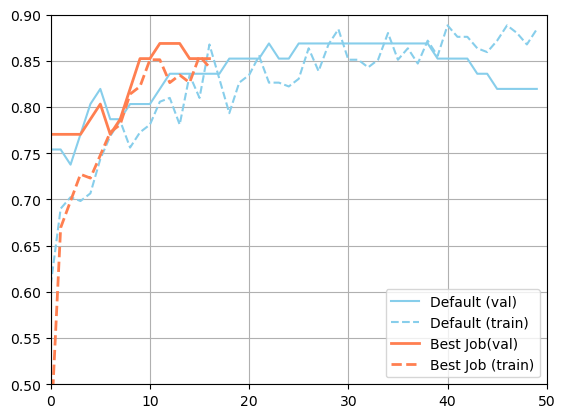

In [37]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(json.loads(metadata_default["val_accuracy"]), color="skyblue", label="Default (val)")
plt.plot(json.loads(metadata_default["accuracy"]), color="skyblue", linestyle="--", label="Default (train)")
plt.plot(json.loads(best_job["m:val_accuracy"]), color="coral", linewidth=2, label="Best Job(val)")
plt.plot(json.loads(best_job["m:accuracy"]), color="coral", linestyle="--", linewidth=2, label="Best Job (train)")
plt.legend()
plt.xlim(0,50)
plt.ylim(0.5, 0.9)
plt.grid()
plt.show()